In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
#import torchtext
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [2]:
train_path = '/opt/ml/input/data/train'
train_image_dir_path = os.path.join(train_path, 'images')

In [3]:
def search(dirname, result): # 하위목록의 모든 파일을 찾는 함수
    try:
        filenames = os.listdir(dirname)
        for filename in filenames:
            if filename[0] == '.': # .으로 시작하는 얘들 거름
                continue
            full_filename = os.path.join(dirname, filename)
            if os.path.isdir(full_filename):
                search(full_filename, result)
            else:
                ext = os.path.splitext(full_filename)[-1] # 확장자 체크
                if ext:
                    result.append(full_filename)
    except PermissionError:
        pass

In [4]:
all_path = []
search(train_image_dir_path, all_path)

In [5]:
len(all_path) # 2700 * 7

18900

In [6]:
all_path[:10]

['/opt/ml/input/data/train/images/001194_male_Asian_25/mask1.jpg',
 '/opt/ml/input/data/train/images/001194_male_Asian_25/mask2.jpg',
 '/opt/ml/input/data/train/images/001194_male_Asian_25/mask4.jpg',
 '/opt/ml/input/data/train/images/001194_male_Asian_25/mask3.jpg',
 '/opt/ml/input/data/train/images/001194_male_Asian_25/normal.jpg',
 '/opt/ml/input/data/train/images/001194_male_Asian_25/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/001194_male_Asian_25/mask5.jpg',
 '/opt/ml/input/data/train/images/006387_male_Asian_19/mask1.jpg',
 '/opt/ml/input/data/train/images/006387_male_Asian_19/mask2.jpg',
 '/opt/ml/input/data/train/images/006387_male_Asian_19/mask4.jpg']

In [7]:
exts = []
for i in all_path:
    ext = os.path.splitext(i)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts) # jpg, png, jpeg, 다 있음

['.jpg', '.jpeg', '.png']


In [8]:
all_path = sorted(all_path)

In [9]:
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:]
    info = info.split('_')
    gender, age = info[1], int(info[3])
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 12
    
    if gender == 'female':
        label += 3
        
    if 30 <= age < 60:
        label += 1
    elif age >= 60:
        label += 2
    
    return label

In [10]:
train_path_label = pd.DataFrame(all_path, columns = ['path'])

train_path_label['label'] = train_path_label['path'].map(lambda x : labeling(x))
train_path_label

,path,label
0,/opt/ml/input/data/train/images/000001_female_...,10
1,/opt/ml/input/data/train/images/000001_female_...,4
2,/opt/ml/input/data/train/images/000001_female_...,4
3,/opt/ml/input/data/train/images/000001_female_...,4
4,/opt/ml/input/data/train/images/000001_female_...,4
...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0
18896,/opt/ml/input/data/train/images/006959_male_As...,0
18897,/opt/ml/input/data/train/images/006959_male_As...,0
18898,/opt/ml/input/data/train/images/006959_male_As...,0


# 🌟 EDA 인사이트 접목해보기 ('age' 그룹화한 컬럼 추가)

In [11]:
def aging(name):
    #label = 0
    info, mask_type = name.split('/')[-2:]
    info = info.split('_')
    gender, age = info[1], int(info[3])
    '''
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 12
    
    if gender == 'female':
        label += 3
        
    if 30 <= age < 60:
        label += 1
    elif age >= 60:
        label += 2
    '''
    
    
    return age

In [12]:
train_path_label['age'] = train_path_label['path'].map(lambda x : aging(x))
train_path_label

,path,label,age
0,/opt/ml/input/data/train/images/000001_female_...,10,45
1,/opt/ml/input/data/train/images/000001_female_...,4,45
2,/opt/ml/input/data/train/images/000001_female_...,4,45
3,/opt/ml/input/data/train/images/000001_female_...,4,45
4,/opt/ml/input/data/train/images/000001_female_...,4,45
...,...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0,19
18896,/opt/ml/input/data/train/images/006959_male_As...,0,19
18897,/opt/ml/input/data/train/images/006959_male_As...,0,19
18898,/opt/ml/input/data/train/images/006959_male_As...,0,19


- 그룹핑 기준을 구하는 코드


```
# index_list = []


# for num in range(1, 7+1):
#     res_index = train_df['age'].quantile(1/7 * num)
#     index_list.append(res_index)
    
    

# index_list # [19.0, 20.0, 25.0, 49.0, 54.0, 58.0, 60.0]
```

In [13]:
new_col = []


for n in train_path_label['age']:
    if n < 19:
        new_col.append(0)
    
    elif n == 19: # 19 살
        new_col.append(1) # 특이값
    
    elif n < 21:
        new_col.append(2)

    elif n <= 25:
        new_col.append(3)
        
    elif n <= 49:
        new_col.append(4)
        
    elif n <= 54:
        new_col.append(5)

    elif n < 58:
        new_col.append(6)
        
    elif n < 60:
        new_col.append(7)
        
    else: ## 딱 60살만
        new_col.append(8)
        
        
new_col[:10]

[4, 4, 4, 4, 4, 4, 4, 5, 5, 5]

In [14]:
train_path_label['age_group'] = np.array(new_col)

In [15]:
train_path_label

,path,label,age,age_group
0,/opt/ml/input/data/train/images/000001_female_...,10,45,4
1,/opt/ml/input/data/train/images/000001_female_...,4,45,4
2,/opt/ml/input/data/train/images/000001_female_...,4,45,4
3,/opt/ml/input/data/train/images/000001_female_...,4,45,4
4,/opt/ml/input/data/train/images/000001_female_...,4,45,4
...,...,...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0,19,1
18896,/opt/ml/input/data/train/images/006959_male_As...,0,19,1
18897,/opt/ml/input/data/train/images/006959_male_As...,0,19,1
18898,/opt/ml/input/data/train/images/006959_male_As...,0,19,1


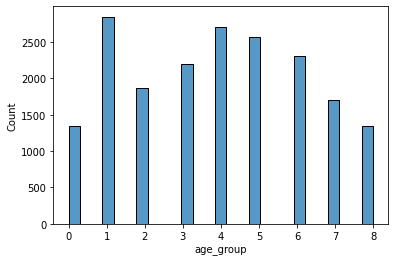

In [16]:
import seaborn as sns

sns.histplot(x='age_group', data=train_path_label)

In [17]:
# train_path_label.to_csv('./train_path_label.csv', index=False, encoding='utf-8')

In [18]:
# train_path_label = pd.read_csv('./train_path_label.csv', encoding='utf-8')

In [19]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_label, transform):
        self.X = img_paths_label['path']
        self.y = img_paths_label['label']
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

    def __len__(self):
        return len(self.X)

In [20]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

# 🌟 그룹화한 나이 정보를 기준으로 균일하게 Train/Test (8:2) split 해본다면 ?

In [21]:
from sklearn.model_selection import train_test_split


train, valid = train_test_split(train_path_label, test_size= 0.2, 
                                shuffle = True, stratify= train_path_label['age_group'], ###train_path_label['label'], 
                                random_state = 34)

In [22]:
train.shape, valid.shape

((15120, 4), (3780, 4))

In [23]:
train

,path,label,age,age_group
15018,/opt/ml/input/data/train/images/005424_male_As...,1,36,4
8541,/opt/ml/input/data/train/images/003183_female_...,3,19,1
14702,/opt/ml/input/data/train/images/005267_male_As...,0,21,3
12494,/opt/ml/input/data/train/images/004237_female_...,16,59,7
2948,/opt/ml/input/data/train/images/001042_male_As...,0,19,1
...,...,...,...,...
10758,/opt/ml/input/data/train/images/003653_male_As...,13,54,5
2043,/opt/ml/input/data/train/images/000713_female_...,16,51,5
17685,/opt/ml/input/data/train/images/006518_female_...,3,19,1
8446,/opt/ml/input/data/train/images/003168_female_...,3,20,2


# 🌟 생성해주었던 'age' 컬럼과 'age_group' 컬럼 다시 삭제해주기

In [24]:
train.columns

Index(['path', 'label', 'age', 'age_group'], dtype='object')

In [25]:
train.drop(['age', 'age_group'], axis=1)

,path,label
15018,/opt/ml/input/data/train/images/005424_male_As...,1
8541,/opt/ml/input/data/train/images/003183_female_...,3
14702,/opt/ml/input/data/train/images/005267_male_As...,0
12494,/opt/ml/input/data/train/images/004237_female_...,16
2948,/opt/ml/input/data/train/images/001042_male_As...,0
...,...,...
10758,/opt/ml/input/data/train/images/003653_male_As...,13
2043,/opt/ml/input/data/train/images/000713_female_...,16
17685,/opt/ml/input/data/train/images/006518_female_...,3
8446,/opt/ml/input/data/train/images/003168_female_...,3


In [26]:
valid.drop(['age', 'age_group'], axis=1)

,path,label
11627,/opt/ml/input/data/train/images/003839_male_As...,7
8007,/opt/ml/input/data/train/images/003092_female_...,15
4490,/opt/ml/input/data/train/images/001320_male_As...,0
17317,/opt/ml/input/data/train/images/006446_female_...,15
9168,/opt/ml/input/data/train/images/003328_female_...,3
...,...,...
7170,/opt/ml/input/data/train/images/001839_male_As...,0
18239,/opt/ml/input/data/train/images/006658_male_As...,0
5251,/opt/ml/input/data/train/images/001488_female_...,4
18841,/opt/ml/input/data/train/images/006948_male_As...,0


In [27]:
BATCH_SIZE = 64

In [28]:
train_dataset = CustomDataset(train, transform)

train_dataloader = DataLoader(train_dataset, 
                        batch_size = BATCH_SIZE, 
                        shuffle = True
                       )

In [29]:
valid_dataset = CustomDataset(valid, transform)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True
                             )

In [30]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

- 에러 : ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

```
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
```

- 이 방법 말고 터미널에 $conda install -c conda-forge ipywidgets
치고선 재시작하는 방법 추천
- (Reference: https://woongheelee.com/entry/%EC%97%90%EB%9F%AC%ED%95%B4%EA%B2%B0%EB%B2%95-ImportError-IProgress-not-found)

In [31]:
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [32]:
import math

OUTPUT_CLASS_NUM = 18
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = OUTPUT_CLASS_NUM, bias = True) # output 18개로

# xavier uniform
torch.nn.init.xavier_uniform_(resnet18.fc.weight) 
stdv = 1. / math.sqrt(resnet18.fc.weight.size(1))
resnet18.fc.bias.data.uniform_(-stdv, stdv)

resnet18.fc.weight.shape[0]

18

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [34]:
from tqdm.notebook import tqdm 

In [35]:
resnet18.to(device)

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션


loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader
}

In [36]:
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train":
            resnet18.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
        elif phase == "test":
            resnet18.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함
        
        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

            with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
                logits = resnet18(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
                loss = loss_fn(logits, labels)

                if phase == "train":
                    loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

        # 한 epoch이 모두 종료되었을 때,
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)

        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
        if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
            best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.485, 평균 Accuracy : 0.853
현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.186, 평균 Accuracy : 0.938
현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.080, 평균 Accuracy : 0.979
현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.106, 평균 Accuracy : 0.965
현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.021, 평균 Accuracy : 0.997
현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.054, 평균 Accuracy : 0.984
현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.008, 평균 Accuracy : 0.999
현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.042, 평균 Accuracy : 0.989
현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.004, 평균 Accuracy : 1.000
현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.043, 평균 Accuracy : 0.988
학습 종료!
최고 accuracy : 0.9886243343353271, 최고 낮은 loss : 0.04208329652464411


In [37]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0,0
        model.eval()
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.to(device))
            _, y_pred = torch.max(model_pred, 1) # 행으로 비교
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        #model.train()
    return val_accr

In [38]:
func_eval(resnet18, valid_dataloader, device)

0.9880952380952381

In [39]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred, 1)

            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [40]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle = False)

check_eval_df = check_eval(valid, valid_testing_dataloader, resnet18, device)
check_eval_df

,path,pred,target
0,/opt/ml/input/data/train/images/003839_male_As...,7,7
1,/opt/ml/input/data/train/images/003092_female_...,15,15
2,/opt/ml/input/data/train/images/001320_male_As...,0,0
3,/opt/ml/input/data/train/images/006446_female_...,15,15
4,/opt/ml/input/data/train/images/003328_female_...,3,3
...,...,...,...
3775,/opt/ml/input/data/train/images/001839_male_As...,0,0
3776,/opt/ml/input/data/train/images/006658_male_As...,0,0
3777,/opt/ml/input/data/train/images/001488_female_...,4,4
3778,/opt/ml/input/data/train/images/006948_male_As...,0,0


In [41]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,/opt/ml/input/data/train/images/003828_female_...,16,15
1,/opt/ml/input/data/train/images/001336_male_As...,16,12
2,/opt/ml/input/data/train/images/004383_male_As...,10,6
3,/opt/ml/input/data/train/images/005549_male_As...,6,7
4,/opt/ml/input/data/train/images/001013_female_...,4,3
5,/opt/ml/input/data/train/images/003865_male_As...,14,13
6,/opt/ml/input/data/train/images/000533_female_...,5,4
7,/opt/ml/input/data/train/images/006339_female_...,12,15
8,/opt/ml/input/data/train/images/003440_male_As...,7,8
9,/opt/ml/input/data/train/images/005143_female_...,4,3


In [42]:
def draw_(df):
    plt.figure(figsize = (15,30))
    row = 7
    for i in range(df.shape[0]):
        plt.subplot(row + 1, df.shape[0]//row, i+1)
        plt.imshow(Image.open(df['path'][i]))
        plt.title(f"target:{df['target'][i]} , pred:{df['pred'][i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

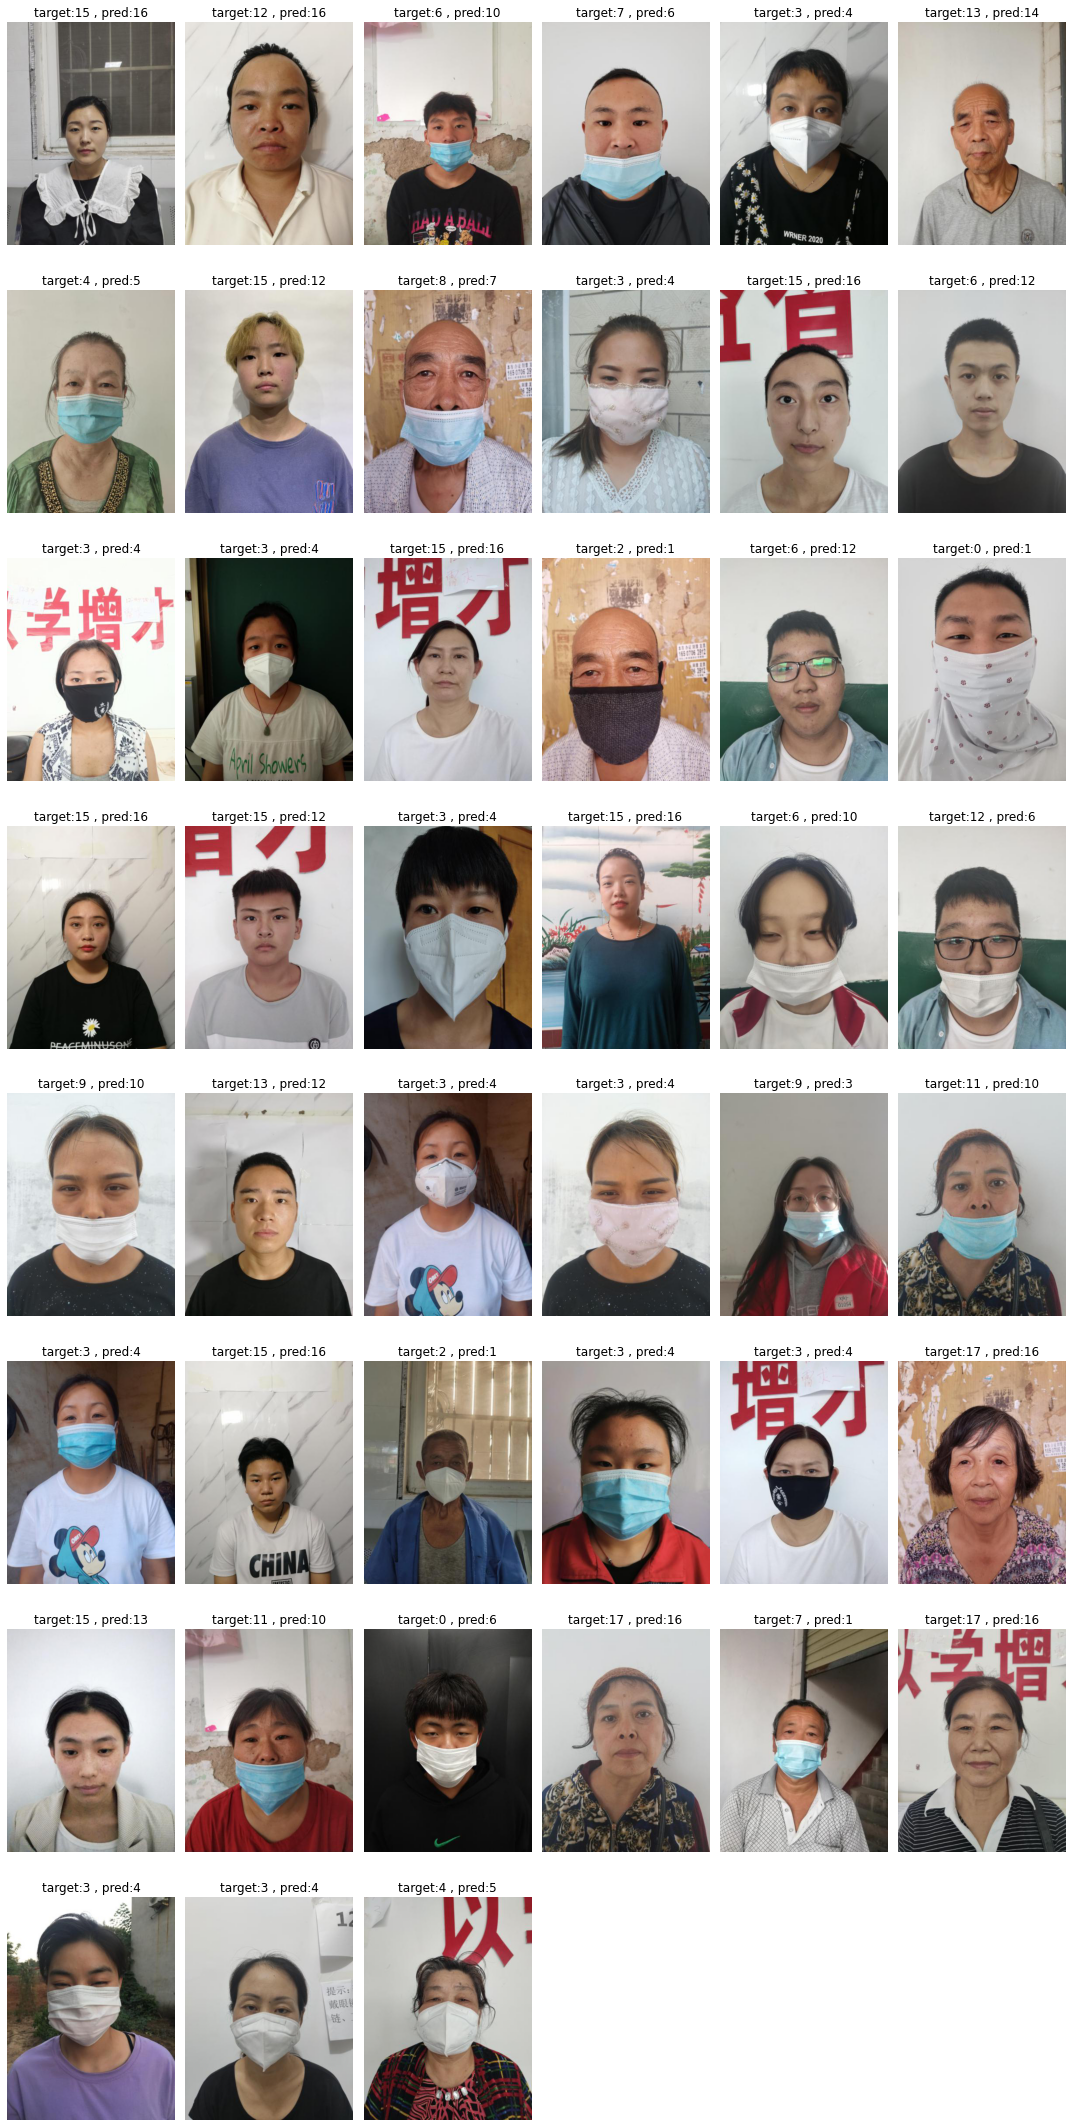

In [43]:
draw_(wrong_df)

# 🌟 test data Inference 코드

In [48]:
# 경로 설정
test_dir = '/opt/ml/input/data/eval'

In [49]:
# 2. Test Dataset 정의
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

- 학습한 모델로부터 정보 불러오기 ("torch.load")

```
# checkpoint = torch.load(PATH)

# model.load_state_dict(checkpoint['model_state_dict'])

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
```

In [51]:
# 3. Inference

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
#####model = MyModel(num_classes=18).to(device)
#####model.eval()

resnet18.to(device)
resnet18.eval()


# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        ####pred = model(images)
        pred = resnet18(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!


In [52]:
submission

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,1
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,4
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1


# 🌟 예측한 submission의 결과 label 값 살펴보기..!!

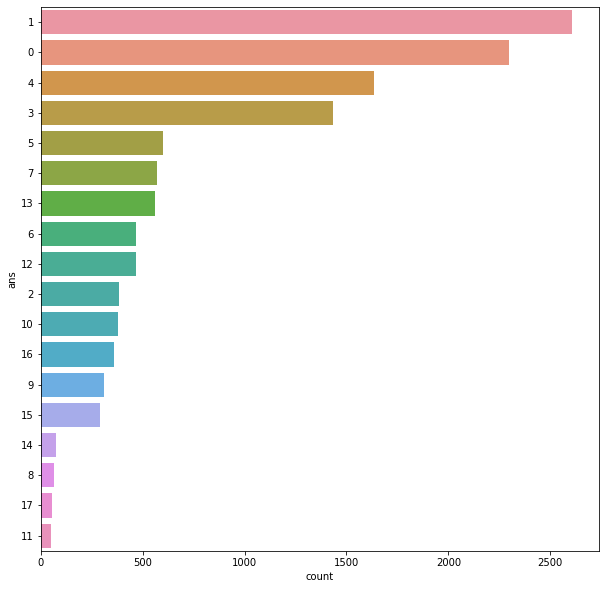

In [54]:
## 예측한 정답별 카운트를 파악해보기..!! (시각화)

fig = plt.figure(figsize= (10, 10))

sns.countplot(y='ans', data=submission, order=submission['ans'].value_counts().index)

In [67]:
label_dic = {0: "Wear & Male & <30",
            1: "Wear & Male & >=30 and <60",
            2: "Wear & Male & >=60",
            3: "Wear & Female & <30",
            4: "Wear & Female & >=30 and <60",
            5: "Wear & Female & >=60",
            6: "Incorrect & Male & <30",
            7: "Incorrect & Male & >=30 and <60",
            8: "Incorrect & Male & >=60",
            9: "Incorrect & Female & <30",
            10: "Incorrect & Female & >=30 and <60",
            11: "Incorrect & Female & >=60",
            12: "Not Wear & Male & <30",
            13: "Not Wear & Male & >=30 and <60",
            14: "Not Wear & Male & >=60",
            15: "Not Wear & Female & <30",
            16: "Not Wear & Female & >=30 and <60",
            17: "Not Wear & Female & >=60"}

In [80]:
df = submission[:][:] ## Deepcopy


df['Predicted Class'] = df['ans'].apply(lambda x: label_dic[x])

In [81]:
df

,ImageID,ans,Predicted Class
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13,Not Wear & Male & >=30 and <60
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1,Wear & Male & >=30 and <60
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13,Not Wear & Male & >=30 and <60
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13,Not Wear & Male & >=30 and <60
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12,Not Wear & Male & <30
...,...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,1,Wear & Male & >=30 and <60
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,4,Wear & Female & >=30 and <60
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9,Incorrect & Female & <30
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1,Wear & Male & >=30 and <60


In [82]:
submission

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,1
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,4
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1


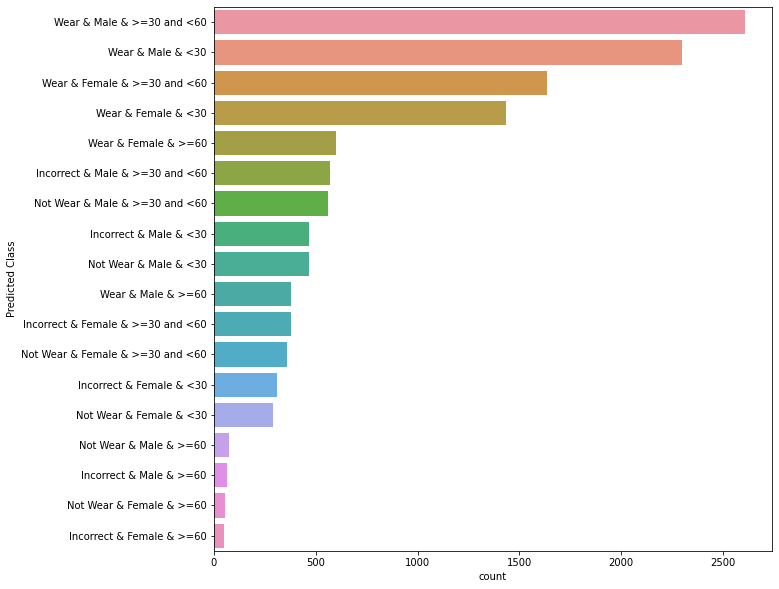

In [83]:
fig = plt.figure(figsize= (10, 10))
sns.countplot(y='Predicted Class', data=df, order=df['Predicted Class'].value_counts().index)

- 정답 Class 기준



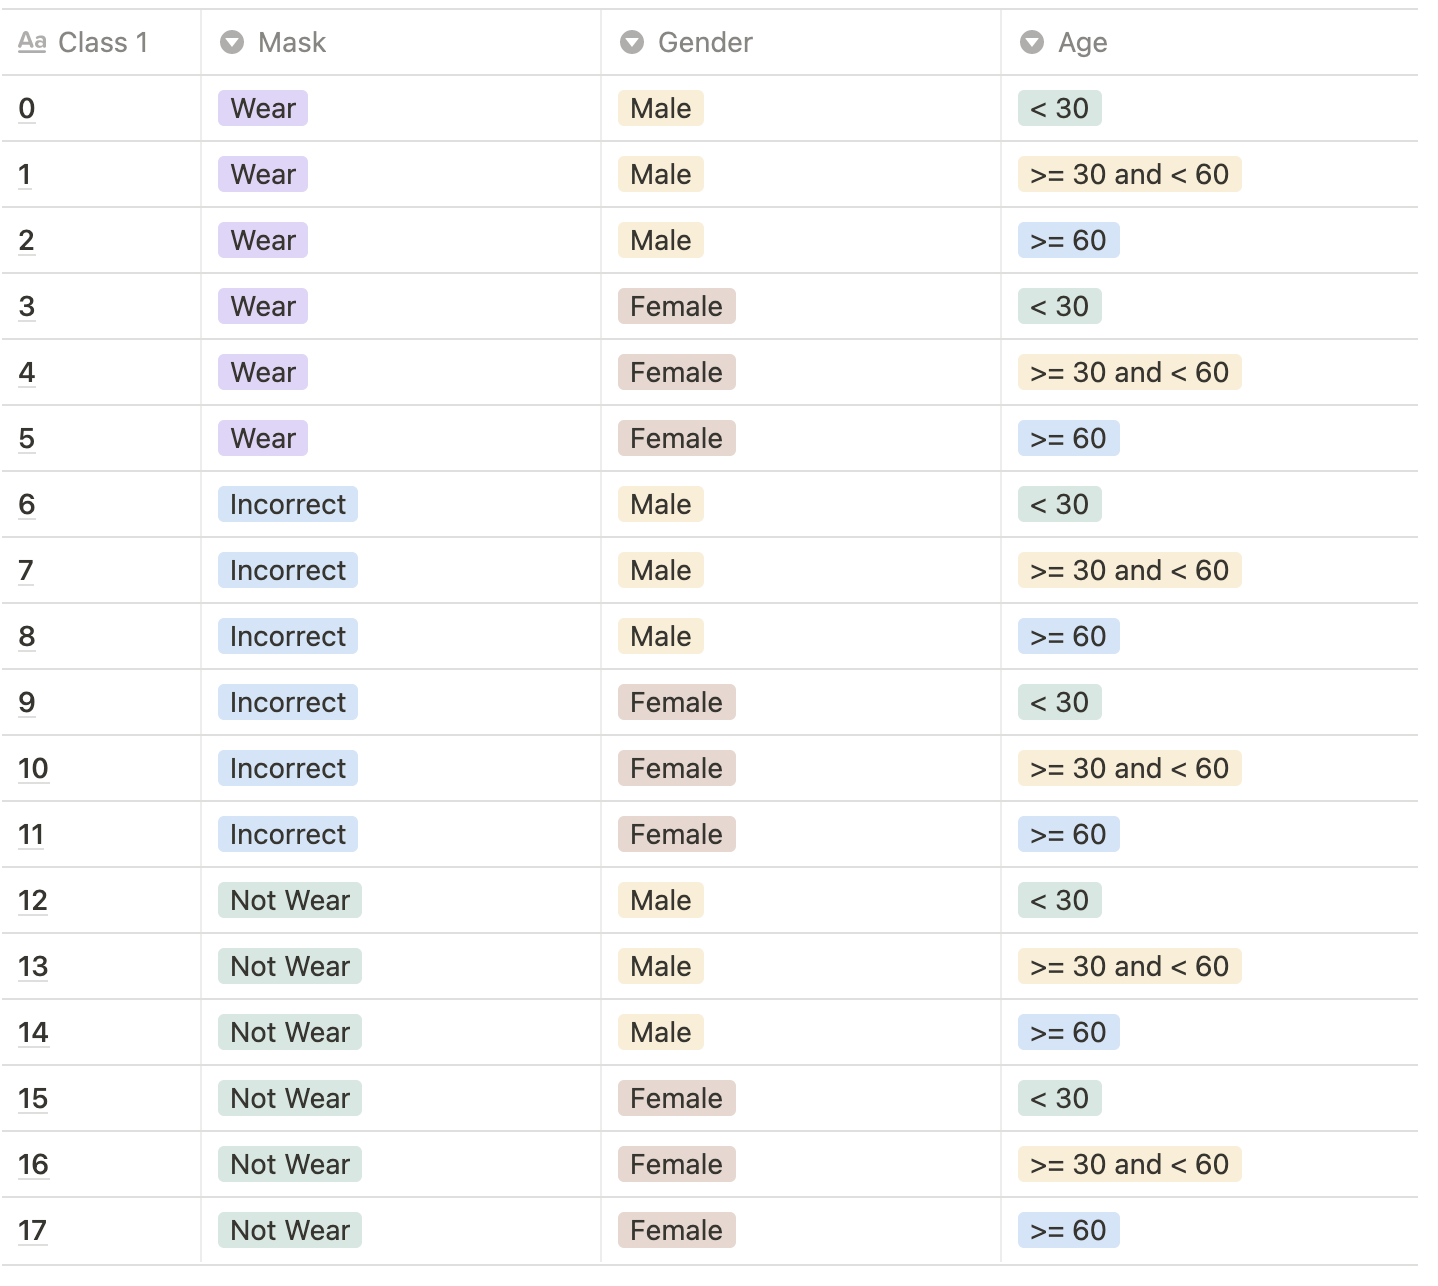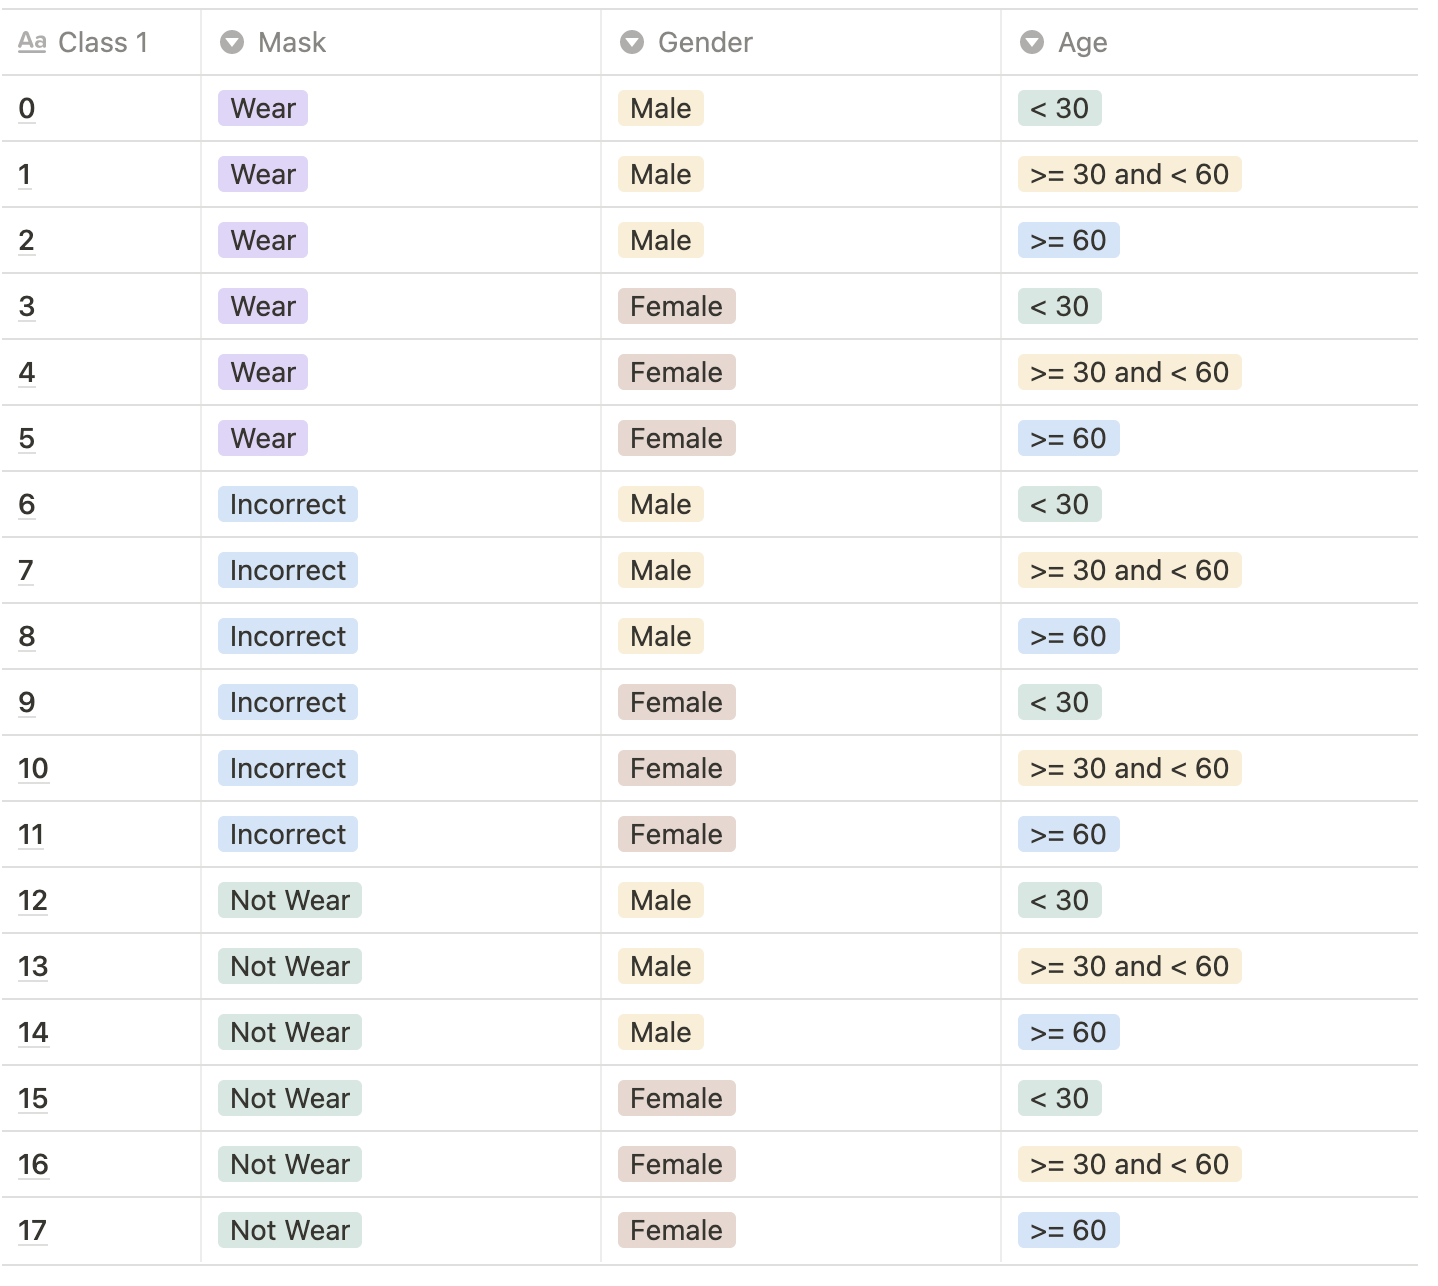